In [1]:
import astropy.units as u
from pixell import enmap, utils
from astropy.wcs import WCS
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import fits
import healpy as hp
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from astropy import wcs
import matplotlib
import coop_setup_funcs as csf
from astropy.cosmology import Planck15 as cosmo, z_at_value
from astropy import units as u


Set region

In [2]:
def get_peakinfo(filename, lonmin, lonmax, latmin, latmax):
    peakfile = fits.open(filename)
    peakinfo = peakfile[0].data
    rot_angle = peakinfo[:,3]
    theta,phi = peakinfo[:,1], peakinfo[:,2]
    dec = []
    ra  = []
    for i in range(len(theta)):
        dec.append(csf.ThetaPhitoRaDec(theta[i],phi[i])[1])
        ra.append(csf.ThetaPhitoRaDec(theta[i],phi[i])[0])

    ra = np.asarray(ra)
    dec = np.asarray(dec)
    in_region = (ra>lonmin+0.1) & (ra < lonmax-0.1) & (dec < latmax-0.1) & (dec > latmin+0.1)
    dec = dec[in_region]
    rot_angle = rot_angle[in_region]
    ra = ra[in_region]
    return (rot_angle,ra,dec)
    peakfile.close()
    
def get_vector_components(rot_angle):
    U_arr = np.zeros(len(rot_angle))
    V_arr = np.zeros(len(rot_angle))
    m = 0
    for r in rot_angle:

        if (r <= np.pi/2.) or (r > 3*np.pi/2.):
            U = 1/np.sqrt(1+np.tan(r)**2)
        else:
            U = -1/np.sqrt(1+np.tan(r)**2)
        V = U * np.tan(r)
        U_arr[m] = U
        V_arr[m] = V
        m += 1
    return U_arr, V_arr

def read_amp_map(amp_file):
    amp_map = fits.open(amp_file)
    amp_map[1].header['TTYPE3'] = 'ID2'
    amp_map.writeto(amp_file, overwrite=True)
    amp_map.close()
    return hp.read_map(amp_file, field=0)

In [3]:
latmin_lrg = -5
latmax_lrg = 7
lonmin_lrg = 0
lonmax_lrg = 40


In [23]:
rot_angle_a_all = []
ra_a_all  = []
dec_a_all = []

rot_angle_a, ra_a, dec_a = get_peakinfo("/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/orient_by_maglim_75/redmapper_lambdagt20_1693_1793Mpc_nugt2_egtpt3_20pt0_orientXYUP_75pct_maglim_1643_1843Mpc_pks.fits", lonmin_lrg, lonmax_lrg, latmin_lrg, latmax_lrg)
print(len(ra_a))
rot_angle_a_all.extend(rot_angle_a)
dec_a_all.extend(dec_a)
ra_a_all.extend(ra_a)
rot_angle_b_all = []
ra_b_all  = []
dec_b_all = []
for reg_b in range(24):
    rot_angle_b, ra_b, dec_b = get_peakinfo("/mnt/scratch-lustre/mlokken/stacking/Buzzard_tSZ_rmpks/{0}/Buzzard_lambdagt10_reg{0}_1632_1832Mpc_nugt2_egtpt3_13pt9_pks.fits".format(reg_b), lonmin_lrg, lonmax_lrg, latmin_lrg, latmax_lrg)
    rot_angle_b_all.extend(rot_angle_b)
    dec_b_all.extend(dec_b)
    ra_b_all.extend(ra_b)

ra_a_all = np.asarray(ra_a_all)
ra_b_all = np.asarray(ra_b_all)
dec_b_all = np.asarray(dec_b_all)
dec_a_all = np.asarray(dec_a_all)
rot_angle_a_all = np.asarray(rot_angle_a_all)
rot_angle_b_all = np.asarray(rot_angle_b_all)

18


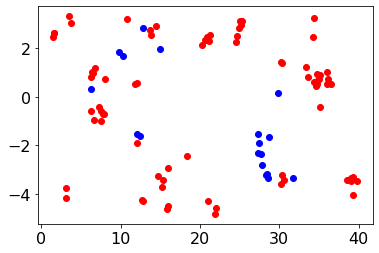

In [24]:
plt.plot(ra_b_all, dec_b_all, 'ro')
plt.plot(ra_a_all, dec_a_all, 'bo')

In [34]:
lonmin = 26
lonmax = 32

latmin = -4
latmax = 2

in_a  = (ra_a_all>lonmin)&(ra_a_all<lonmax)&(dec_a_all>latmin)&(dec_a_all<latmax)
ra_a  = ra_a_all[in_a]
dec_a = dec_a_all[in_a]
in_b  = (ra_b_all>lonmin)&(ra_b_all<lonmax)&(dec_b_all>latmin)&(dec_b_all<latmax)
ra_b  = ra_b_all[in_b]
dec_b = dec_b_all[in_b]
rot_angle_a = rot_angle_a_all[in_a]
rot_angle_b = rot_angle_b_all[in_b]
print(ra_a)

[28.6083976  27.36694413 28.48754936 27.78442407 27.6965332  27.36694413
 28.72924755 28.32275397 31.7834486  29.81689371 27.46581965]


In [35]:
len(ra_a), len(dec_a), len(ra_b), len(dec_b)

(11, 11, 5, 5)

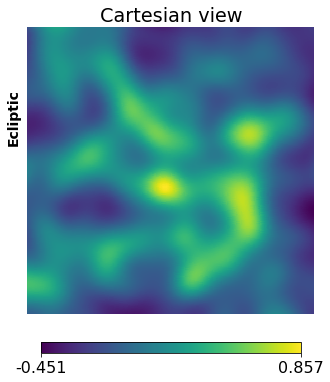

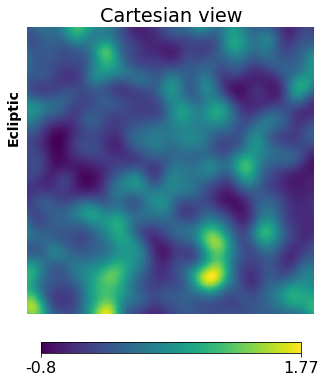

In [36]:
nd_map_smooth_a = read_amp_map("/mnt/raid-cita/mlokken/data/number_density_maps/maglim/odmap_75_1643_1843Mpc_AMPLITUDE_fwhm39a.fits")
nd_map_flat_a   = hp.cartview(nd_map_smooth_a, latra=[latmin,latmax], lonra=[lonmin,lonmax], return_projected_map=True, coord='E')
nd_map_smooth_b = read_amp_map("/mnt/raid-cita/mlokken/buzzard/number_density_maps/des_reg/odmap_distMpc_1632_1832_0Mpc_0arcmin_AMPLITUDE_fwhm27a.fits")
nd_map_flat_b   = hp.cartview(nd_map_smooth_b, latra=[latmin,latmax], lonra=[lonmin,lonmax], return_projected_map=True, coord='E')


In [37]:
a = wcs.WCS(naxis=2)

height = float(nd_map_flat_a.shape[0])
length = float(nd_map_flat_a.shape[1])
cdeltaX, crvalX = (lonmin-lonmax)/length, (lonmin+lonmax)/2.
cdeltaY, crvalY = (latmin-latmax)/height, (latmin+latmax)/2.
a.wcs.crpix = length/2., height/2.
print(a.wcs.crpix)
a.wcs.crval = [crvalX,crvalY]
print(a.wcs.crval)
a.wcs.cdelt = np.array([cdeltaX,cdeltaY])
print(a.wcs.cdelt)
a.wcs.ctype = ["RA", "DEC"]
Xpix_a,Ypix_a = a.all_world2pix(ra_a,dec_a,0)

b = wcs.WCS(naxis=2)
height = float(nd_map_flat_b.shape[0])
length = float(nd_map_flat_b.shape[1])
cdeltaX, crvalX = (lonmin-lonmax)/length, (lonmin+lonmax)/2.
cdeltaY, crvalY = (latmin-latmax)/height, (latmin+latmax)/2.
b.wcs.crpix = length/2., height/2.
print(b.wcs.crpix)
b.wcs.crval = [crvalX,crvalY]
print(b.wcs.crval)
b.wcs.cdelt = np.array([cdeltaX,cdeltaY])
print(b.wcs.cdelt)
b.wcs.ctype = ["RA", "DEC"]
Xpix_b,Ypix_b = b.all_world2pix(ra_b,dec_b,0)

[400. 400.]
[29. -1.]
[-0.0075 -0.0075]
[400. 400.]
[29. -1.]
[-0.0075 -0.0075]


In [38]:
np.amax(nd_map_flat_a)

0.8573355078697205

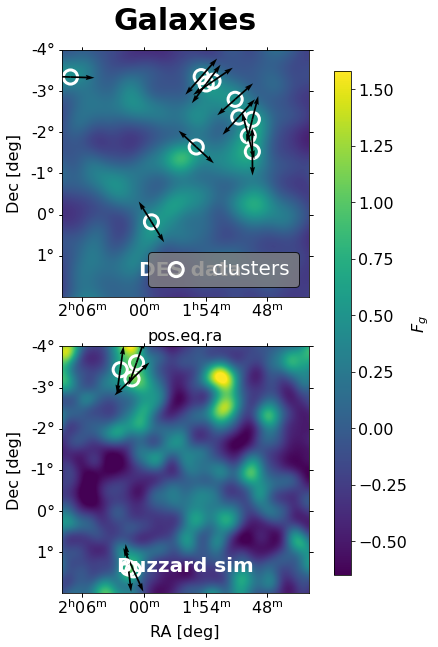

In [39]:
# # Make the figure


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=[8,10])
ax1 = plt.subplot(211, projection=a)
ax2 = plt.subplot(212, projection=b)

U_arr_a, V_arr_a = get_vector_components(rot_angle_a)
U_arr_b, V_arr_b = get_vector_components(rot_angle_b)
delta = ax1.imshow(nd_map_flat_a[::-1], vmin=-0.65, vmax=1.58)

ax1.scatter(Xpix_a, Ypix_a, s=200,edgecolor='white', facecolor='none', linewidths=3, label='clusters')
ax1.quiver(Xpix_a, Ypix_a, -U_arr_a, V_arr_a, width=0.007, color = 'k', scale = 3, scale_units = 'inches')
ax1.quiver(Xpix_a, Ypix_a, U_arr_a, -V_arr_a, width=0.007, color = 'k', scale = 3, scale_units = 'inches')
ax2.imshow(nd_map_flat_b[::-1], vmin=-0.65, vmax=1.58)
ax2.scatter(Xpix_b, Ypix_b, s=200,edgecolor='white', facecolor='none', linewidths=3)
ax2.quiver(Xpix_b, Ypix_b, -U_arr_b, V_arr_b, width=0.007, color = 'k', scale = 3, scale_units = 'inches')
ax2.quiver(Xpix_b, Ypix_b, U_arr_b, -V_arr_b, width=0.007, color = 'k', scale = 3, scale_units = 'inches')
l = ax1.legend(loc='lower right', facecolor='grey', edgecolor='k', fontsize=20)
for text in l.get_texts():
    text.set_color("white")

ax1.text(250,70,"DES data", color='white', fontsize=20, fontweight='bold')
ax2.text(180,70,"Buzzard sim", color='white', fontsize=20, fontweight='bold')
# ax1.text(300,300,"DES data", color='white', fontsize=20, fontweight='bold')
ax1.set_title("Galaxies", fontsize=30, pad=20, fontweight='bold')

cbar_ax = fig.add_axes([0.77, 0.15, 0.03, 0.7])
cb = fig.colorbar(delta, cax=cbar_ax)
cb.set_label(label='$F_g$',fontsize=16)
ax1.set_ylabel("Dec [deg]")
ax2.set_ylabel("Dec [deg]")
ax2.set_xlabel("RA [deg]")
# plt.show()
# plt.savefig("/home/mlokken/oriented_stacking/plots/vis/3panel_deltag.png")


In [40]:
ymap_a = hp.read_map("/mnt/raid-cita/mlokken/data/act_ymaps/ilc_SZ_yy_4096_hpx.fits")
ymap_b = hp.read_map("/mnt/raid-cita/mlokken/buzzard/ymaps/ymap_buzzard_standard_bbps_car_1p6arcmin_cutoff4_4096_hpx.fits")

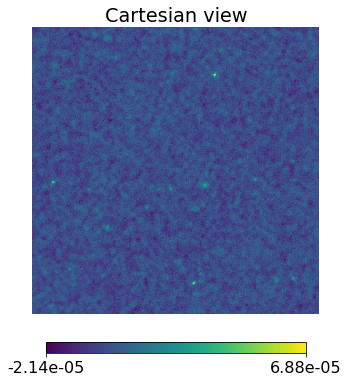

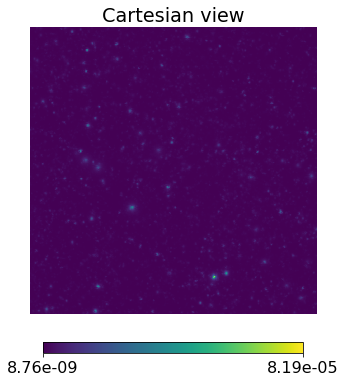

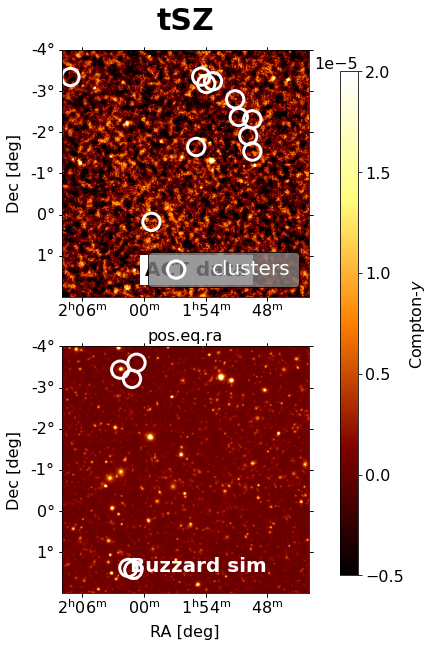

In [41]:
img_a = hp.cartview(ymap_a, latra=[latmin,latmax], lonra=[lonmin,lonmax], return_projected_map=True)
img_b = hp.cartview(ymap_b, latra=[latmin,latmax], lonra=[lonmin,lonmax], return_projected_map=True)
# Make the figure

fig = plt.figure(figsize=[7,10])
ax1 = plt.subplot(211, projection=a)
ax2 = plt.subplot(212, projection=b)
yplot_a = ax1.imshow(img_a[::-1], cmap='afmhot', vmin=-5e-6, vmax=2e-5)
yplot_b = ax2.imshow(img_b[::-1], cmap='afmhot', vmin=-5e-6, vmax=2e-5)

ax1.scatter(Xpix_a, Ypix_a, s=300,edgecolor='white', facecolor='none', linewidths=3, label='clusters')
ax2.scatter(Xpix_b, Ypix_b, s=300,edgecolor='white', facecolor='none', linewidths=3)
fig.subplots_adjust(right=.8)
cbar_ax = fig.add_axes([.77, 0.15, 0.035, 0.7])
ax1.text(270,70,"ACT data", backgroundcolor='white', color='k', fontsize=20, fontweight='bold')
ax2.text(220,70,"Buzzard sim", color='w', fontsize=20, fontweight='bold')
l = ax1.legend(loc='lower right', facecolor='grey', edgecolor='k', fontsize=20)
for text in l.get_texts():
    text.set_color("white")
cb = fig.colorbar(yplot_a, cax=cbar_ax)
cb.formatter.set_powerlimits((0, 0))
ax1.set_title("tSZ", fontsize=30, pad=20, fontweight='bold')
cb.set_label('Compton-$y$', fontsize=16)
cb.update_ticks()

ax1.set_ylabel("Dec [deg]")
ax2.set_xlabel("RA [deg]")
ax2.set_ylabel("Dec [deg]")

# plt.show()
# plt.tight_layout()
# plt.savefig("/home/mlokken/oriented_stacking/plots/vis/3panel_y.png", dpi=300)



In [42]:
rad_in_Mpc = cosmo.kpc_comoving_per_arcmin(z_at_value(cosmo.comoving_distance,(1032+1232)/2.*u.Mpc)).to(u.Mpc/u.deg)*2*u.deg

<Figure size 576x720 with 0 Axes>

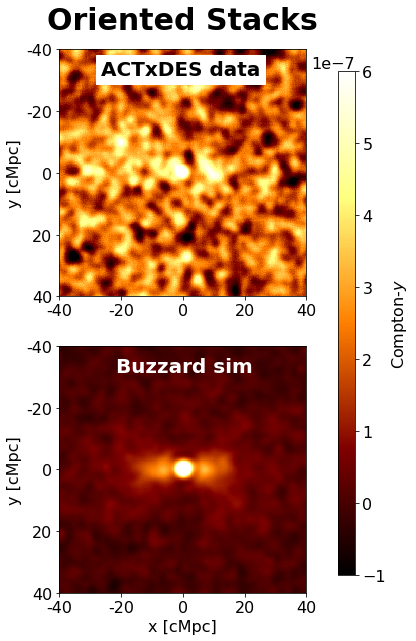

In [73]:

fig = plt.figure(figsize=[8,10])

act_img = np.loadtxt("/mnt/scratch-lustre/mlokken/stacking/ACT+Planck/ACTxDES_lambdagt10_1032_2632Mpc_13pt9Mpc_nugt2_egtpt3_smth_12regallreg_combined_stack.txt")
buzz_img = np.loadtxt("/mnt/scratch-lustre/mlokken/stacking/Buzzard_tSZ_rmpks/Buzzard_lambdagt10_1032_2632Mpc_13pt9Mpc_nugt2_egtpt3_smth_24regallreg_combined_stack.txt")

fig, ax = plt.subplots(nrows=2,ncols=1, figsize=[7,10])

# smoothplot_act = ax[0].imshow(np.flipud(ndimage.gaussian_filter(act_img, sigma=0)), cmap='afmhot', vmin=-1e-7, vmax=7e-7)
# smoothplot_buzz = ax[1].imshow(np.flipud(ndimage.gaussian_filter(buzz_img, sigma=0)), cmap='afmhot', vmin=-1e-7, vmax=7e-7)
smoothplot_act = ax[0].imshow(np.flipud(act_img), cmap='afmhot', vmin=-1e-7, vmax=6e-7)
smoothplot_buzz = ax[1].imshow(np.flipud(buzz_img), cmap='afmhot', vmin=-1e-7, vmax=6e-7)
locs = []
for i in range(9):
    locs.append(i/8. * act_img.shape[0])

labels = []
mpc_per_pix = rad_in_Mpc / (act_img.shape[0]//2)
for loc in locs:
    labels.append(round((loc-act_img.shape[0]//2) * mpc_per_pix.value))

ax[1].set_xlabel("x [cMpc]")
ax[1].set_ylabel("y [cMpc]")
ax[0].set_ylabel("y [cMpc]")
for i in range(2):
    ax[i].set_xticks(locs[::2])
    ax[i].set_xticklabels(labels[::2])
    ax[i].set_yticks(locs[::2])
    ax[i].set_yticklabels(labels[::2])
ax[0].text(80,50,"ACTxDES data", backgroundcolor='white', color='k', fontsize=20, fontweight='bold')
ax[1].text(110,50,"Buzzard sim", color='white', fontsize=20, fontweight='bold')
ax[0].set_title("Oriented Stacks", fontsize=30, pad=20, fontweight='bold')
cbar_ax = fig.add_axes([0.82, 0.15, 0.035, 0.7])
fig.colorbar(smoothplot_act, cax=cbar_ax, label='Compton-$y$')
plt.savefig("/home/mlokken/oriented_stacking/plots/vis/3panel_stacks.png")
# cbar_ax.formatter.set_powerlimits((0, 0))
# cbar.set_label('Compton-$y$')
# cbar.update_ticks()


